# 1. Data Preparation

### Loading Packages

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
# also install necessary dependencies of the excel plugin of pandas

## Data: Bray et al. (2017)

The Cell Image Library has a “Human U2OS Cell: Compound Cell-Painting Experiment” project data that contains the images of 375 plates in 384-well format (More details: https://www.cellimagelibrary.org/pages/project_20269): 

- The images are of U2OS cells treated with each of over 30,000 known bioactive compounds.
- These cells are labeled with 6 labels that characterize seven organelles (the cell-painting assay).
- The data set is comprised of 988,994 fields of view.
- Each field was imaged in five channels (detection wavelengths), and each channel is stored as a separate, grayscale image file.
- As a result, there are approximately 5 million image files in 16-bit TIFF format.

Bray et al. (2017)’s research uses the raw image data of, and includes highly multiplexed measurements of cellular morphology of the tested compounds from the above Human U2OS Cell research. It includes:

- data files containing morphological features derived from each cell in each image (both at the single-cell level and population-averaged, i.e. per-well level),
- the image analysis workflows that generated the morphological features,
- quality-control metrics are provided as metadata,
- chemical annotations for the applied compound treatments.

- Description and files: http://gigadb.org/dataset/view/id/100351/Files_page/1
- Codebase: https://github.com/gigascience/paper-bray2017/tree/master


### Functions for SQLite Databases

In [16]:
# function for moving a column to a new position
def move_column(df, col_name, new_position):
    temp_col = df[col_name]
    df = df.drop(columns=[col_name])
    df.insert(new_position, col_name, temp_col)
    return df

# function for converting a column to numeric
def convert_to_numeric(df):
    for col in df.columns:
        # Attempt to convert the column to numeric, setting errors='ignore' keeps the original data if conversion fails
        df[col] = pd.to_numeric(df[col], errors='ignore')
    return df

# function for getting the memory size of an object
def memory_size(bytes_size: int) -> str:
    for unit in ['Bytes', 'KB', 'MB', 'GB', 'TB']:
        if bytes_size < 1024:
            return f"{bytes_size:.2f} {unit}"
        bytes_size /= 1024
    return f"{bytes_size:.2f} PB"

In [78]:
# funtion for retrieving the sql database connector
def get_db_conn(db_path: str):
    try:
        conn = sql.connect(db_path) # connect to the SQLite database
        return conn
    except sql.Error as e:
        print(f"An error occurred while accessing the database: {e}")
        pass

# function for connecting a database object and returning its connector cursor
def get_db_cursor(db_path: str):
    try:
        conn = sql.connect(db_path) # connect to the SQLite database
        cursor = conn.cursor() # create a cursor object to execute SQL queries
        return cursor
    except sql.Error as e:
        print(f"An error occurred while accessing the database: {e}")
        pass

# function for viewing the available database tables
def get_db_tables(cursor: sql.Cursor):
    try:
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") # cursor execution for retrieving the list of all tables
        db_tables = cursor.fetchall() # fetch the command output in a list object

        # view the list of tables
        temp = []
        for table in db_tables:
            temp.append(table[0])
        
        db_tables = temp
        return db_tables
    
    except sql.Error as e:
        print(f"An error occurred while accessing the database: {e}")
        return []

# function for extracting all available table columns in a dictionary
def get_db_columns(cursor: sql.Cursor):
    db_columns = {}
    
    for table in get_db_tables(cursor=cursor):
        cursor.execute(f"PRAGMA table_info({table});") # cursor call for retrieving table information
        cursor_output = cursor.fetchall() # cursor fetch operation to retrieve the SQL command output
        columns = [col[1] for col in cursor_output]
        db_columns[table] = columns

    for table in db_columns:
        print(f'{table}: {len(db_columns[table])} Columns')
        print(f'{table}: {db_columns[table]} Columns\n')

    return db_columns

# function for printing out the database table sizes
def get_db_size(cursor: sql.Cursor):
    for table in get_db_tables(cursor=cursor):
        # cursor call for executing SQL command 
        cursor.execute(f"SELECT COUNT(*) FROM {table};") 
        # fetch the first element of the cursor call output
        row_count = cursor.fetchone()[0] 
        
        # cursor command for retrieving column information
        cursor.execute(f"PRAGMA table_info({table});") 
        column_count = len(cursor.fetchall())
        
        # print the dimension and size information of each table
        print(f"{table} | Rows: {row_count} | Columns: {column_count} | Datapoints: {(row_count * column_count / 1000000):.1f}M")

def add_id_info(df_tables: dict):
    for table in df_tables.keys():
        if table == 'Image':
            # Split the FileName column into well information and picture number
            df_tables[table]['WellID'] = df_tables[table]['Image_FileName_CellOutlines'].str.split('--').str[0].str.split('_').str[0]
            df_tables[table]['FieldID'] = df_tables[table]['Image_FileName_CellOutlines'].str.split('--').str[0].str.split('_').str[1]
        else:
            # adding well ID and field ID to other tables
            df_tables[table] = df_tables[table].merge(df_tables['Image'][['TableNumber', 'WellID', 'FieldID']], on='TableNumber', how='left')
    
    return df_tables

def fix_columns(df_tables: dict):
    for table in df_tables:
        # change TableNumber to tableID in all of the tables
        df_tables[table].rename(columns={'TableNumber': 'TableID'}, inplace=True)

        # fix the order of the newly added columns
        df_tables[table] = move_column(df_tables[table], 'PlateID', 1)
        df_tables[table] = move_column(df_tables[table], 'WellID', 2)
        df_tables[table] = move_column(df_tables[table], 'FieldID', 3)

        # convert all numeric columns to float
        if table in ['Cells', 'Cytoplasm', 'Nuclei']:
            for eachColumn in df_tables[table].columns:
                if 'AreaShape' in eachColumn:
                    try:
                        # replace 'nan' strings with np.nan
                        df_tables[table][eachColumn] = df_tables[table][eachColumn].replace('nan', np.nan)
                        # attempt to convert the column to numeric type
                        df_tables[table][eachColumn] = pd.to_numeric(df_tables[table][eachColumn])
                        # print(f"Converted column '{eachColumn}' in table '{table}' to numeric.")
                    except ValueError:
                        # if conversion fails, leave the column unchanged
                        print(f"Could not convert column '{eachColumn}' in table '{table}'. Leaving it unchanged.")
    return df_tables

### Loading SQLite Databases

In [82]:
# list of plate IDs being extracted
analysis_mode = 'test'
plate_list = {'live': [24278, 24279, 24280, 24293, 24294, 24295, 24296, 24297, 24300, 24301, 24302, 24303],
              'test': [24278, 24279]}

# dictionary of required columns inside each of the sqlite database tables
df_columns = {}
df_columns['Image'] = ['TableNumber', 'Image_Count_Cells', 'Image_Count_Cytoplasm', 'Image_Count_Nuclei', 'Image_ExecutionTime_01LoadData', 'Image_ExecutionTime_02CorrectIlluminationApply', 'Image_ExecutionTime_03MeasureImageQuality', 'Image_ExecutionTime_04MeasureImageQuality', 'Image_ExecutionTime_06IdentifyPrimaryObjects', 'Image_ExecutionTime_07IdentifySecondaryObjects', 'Image_ExecutionTime_08IdentifyTertiaryObjects', 'Image_ExecutionTime_09MeasureCorrelation', 'Image_ExecutionTime_10MeasureGranularity', 'Image_ExecutionTime_11MeasureObjectIntensity', 'Image_ExecutionTime_12MeasureObjectNeighbors', 'Image_ExecutionTime_13MeasureObjectNeighbors', 'Image_ExecutionTime_14MeasureObjectNeighbors', 'Image_ExecutionTime_15MeasureObjectIntensityDistribution', 'Image_ExecutionTime_16MeasureObjectSizeShape', 'Image_ExecutionTime_17MeasureTexture', 'Image_ExecutionTime_18OverlayOutlines', 'Image_ExecutionTime_19OverlayOutlines', 'Image_ExecutionTime_20SaveImages', 'Image_ExecutionTime_21SaveImages', 'Image_FileName_CellOutlines', 'Image_FileName_IllumAGP', 'Image_FileName_IllumDNA', 'Image_FileName_IllumER', 'Image_FileName_IllumMito', 'Image_FileName_IllumRNA', 'Image_FileName_NucleiOutlines', 'Image_FileName_OrigAGP', 'Image_FileName_OrigDNA', 'Image_FileName_OrigER', 'Image_FileName_OrigMito', 'Image_FileName_OrigRNA']
df_columns['Nuclei'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_EulerNumber', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_MajorAxisLength', 'Nuclei_AreaShape_MaxFeretDiameter', 'Nuclei_AreaShape_MaximumRadius', 'Nuclei_AreaShape_MeanRadius', 'Nuclei_AreaShape_MedianRadius', 'Nuclei_AreaShape_MinFeretDiameter', 'Nuclei_AreaShape_MinorAxisLength', 'Nuclei_AreaShape_Orientation', 'Nuclei_AreaShape_Perimeter', 'Nuclei_AreaShape_Solidity']
df_columns['Cytoplasm'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Cytoplasm_AreaShape_Area', 'Cytoplasm_AreaShape_Center_X', 'Cytoplasm_AreaShape_Center_Y', 'Cytoplasm_AreaShape_Compactness', 'Cytoplasm_AreaShape_Eccentricity', 'Cytoplasm_AreaShape_EulerNumber', 'Cytoplasm_AreaShape_Extent', 'Cytoplasm_AreaShape_FormFactor', 'Cytoplasm_AreaShape_MajorAxisLength', 'Cytoplasm_AreaShape_MaxFeretDiameter', 'Cytoplasm_AreaShape_MaximumRadius', 'Cytoplasm_AreaShape_MeanRadius', 'Cytoplasm_AreaShape_MedianRadius', 'Cytoplasm_AreaShape_MinFeretDiameter', 'Cytoplasm_AreaShape_MinorAxisLength', 'Cytoplasm_AreaShape_Orientation', 'Cytoplasm_AreaShape_Perimeter', 'Cytoplasm_AreaShape_Solidity']
df_columns['Cells'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Cells_AreaShape_Area', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_FormFactor', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaximumRadius', 'Cells_AreaShape_MeanRadius', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinorAxisLength', 'Cells_AreaShape_Orientation', 'Cells_AreaShape_Perimeter', 'Cells_AreaShape_Solidity']

# create a blank dictionary to save each table as a dataframe
df_tables = {}
# initialize the dictionary with creating each table with specified columns + plateID column
for table in df_columns.keys():
    df_tables[table] = pd.DataFrame(columns=df_columns[table] + ['PlateID'])

for plate in plate_list[analysis_mode]:

    # update path to the sqlite database
    db_path = '../Data/bray2017/'+str(plate)+'/extracted_features/'+str(plate)+'.sqlite'
    # update db connector and cursor
    conn = get_db_conn(db_path=db_path)
    cursor = get_db_cursor(db_path=db_path)

    for table in get_db_tables(cursor):
        # update the query with the next table name and column information
        query = f"SELECT {', '.join(df_columns[table])} FROM {table};"
        # extract the dataframe using query
        temp = pd.read_sql_query(query, conn)

        # add plateID information to newly extracted dataframe
        temp['PlateID'] = plate

        # append the fresh dataframe with the existing dataframe
        df_tables[table] = pd.concat([df_tables[table], temp], ignore_index=True)
        print(f"PlateID: {plate} - Table: {table} | Success")

# add wellID and fieldID information to all dataframes
df_tables = add_id_info(df_tables)

# fix the column orders and data types
df_tables = fix_columns(df_tables)

/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_9874/3621402863.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_tables[table] = pd.concat([df_tables[table], temp], ignore_index=True)


PlateID: 24278 - Table: Image | Success


/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_9874/3621402863.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_tables[table] = pd.concat([df_tables[table], temp], ignore_index=True)


PlateID: 24278 - Table: Nuclei | Success


/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_9874/3621402863.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_tables[table] = pd.concat([df_tables[table], temp], ignore_index=True)


PlateID: 24278 - Table: Cytoplasm | Success


/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_9874/3621402863.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_tables[table] = pd.concat([df_tables[table], temp], ignore_index=True)


PlateID: 24278 - Table: Cells | Success
PlateID: 24279 - Table: Image | Success
PlateID: 24279 - Table: Nuclei | Success
PlateID: 24279 - Table: Cytoplasm | Success
PlateID: 24279 - Table: Cells | Success


/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_9874/2584471716.py:97: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tables[table][eachColumn] = df_tables[table][eachColumn].replace('nan', np.nan)
/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_9874/2584471716.py:97: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tables[table][eachColumn] = df_tables[table][eachColumn].replace('nan', np.nan)


### (Optional) Exporting CSV

In [86]:
# # set up the query parameters
# # table_name = 'Image'
# row_limit = 3

# for table in db_tables:
#     print(f"\n{table}")

#     cursor.execute(f"PRAGMA table_info({table});") # cursor call for retrieving table information
#     columns = cursor.fetchall()
#     column_names = [col[1] for col in columns]
#     print(column_names)

#     query = f"SELECT * FROM {table} LIMIT {row_limit};"  # set up the query using parameters
#     cursor.execute(query) # execute the cursor call using the query
#     rows = cursor.fetchall() # fetch the output of the cursor
#     for row in rows:
#         print(row)

# sampleDataframes = {} # create a blank dictionary to save each table as a dataframe, with a table_name key
# row_limit = 10

# for table in db_tables: # loop through all tables 
    
#     query = f"SELECT * FROM {table} LIMIT {row_limit};"  # set up the query using parameters
#     df = pd.read_sql_query(query, conn) # use the open connector to pull table into

#     sampleDataframes[table] = df # store the sample df in the dictionary
#     print(f"Table {table} has been saved.")

# for table_name, df in sampleDataframes.items():
#     # Export each DataFrame to a CSV file
#     df.to_csv(f"{table_name}.csv", index=False)  # index=False avoids writing row numbers
#     print(f"Exported {table_name} to {table_name}.csv")


In [18]:
# close the connection when the sqlite database processing is done
conn.close()

## Data: Biomorph (2024)

Ola linked the compounds identified in the BioMorph study with the metadata of the Cell Painting dataset. She linked 603 compounds, which results in 5025 wells spread over 94 different plates.
- CPD_NAME: specific compounds
- Metadata_Plate: specific plates
- Metadata_Well: specific wells

### Endpoint Definitions

1. Apoptosis Up:
- Apoptosis is the process of programmed cell death, where cells die in a controlled manner as part of normal development or in response to damage.
- "**Apoptosis up**" means an increase in the rate of apoptosis in response to a compound, suggesting the compound is inducing cell death via the apoptotic pathway. This could be important in cancer treatments, where the goal is to promote the death of harmful cells.
 2. Cytotoxicity BLA:
- Cytotoxicity refers to the toxic effect a compound has on cells, leading to cell damage or death.
- BLA stands for Beta-Lactamase assay, a biochemical assay often used to detect cytotoxicity. The "**Cytotoxicity BLA**" endpoint indicates cell death or damage measured through the Beta-Lactamase assay.
 3. Cytotoxicity SRB:
- Similar to Cytotoxicity BLA, this measures cell toxicity, but using a different assay.
- SRB stands for Sulforhodamine B, a dye that binds to cellular proteins, and it’s commonly used to measure cell density and viability. The "**Cytotoxicity SRB**" endpoint measures the cytotoxic effect of compounds based on the amount of protein-bound SRB dye, indicating cell death or reduced viability.
 4. ER Stress:
- ER stress refers to stress in the Endoplasmic Reticulum (ER), a cell organelle involved in protein folding and secretion. When misfolded proteins accumulate, ER stress triggers the Unfolded Protein Response (UPR).
- The "ER stress" endpoint indicates that a compound is causing stress in the ER, potentially leading to apoptosis or other cellular dysfunctions.
 5. Heat Shock:
- Heat shock refers to the stress response of cells to elevated temperatures, which results in the production of heat shock proteins (HSPs) that help protect cells from damage.
- The "Heat Shock" endpoint suggests the compound is inducing a cellular response similar to what happens when cells are exposed to heat or other stresses, typically leading to the production of HSPs.
 6. Microtubule Up:
- Microtubules are part of the cell's cytoskeleton and are crucial for cell division and intracellular transport.
- "Microtubule up" indicates an increase in microtubule stabilization or polymerization due to the compound. Compounds that affect microtubules can disrupt cell division, making this endpoint important in cancer research (e.g., chemotherapy drugs like taxanes target microtubules).
 7. Mitochondrial Disruption Up:
- Mitochondria are the energy-producing organelles in cells, and mitochondrial disruption can lead to cell death or dysfunction.
- "Mitochondrial disruption up" indicates an increase in mitochondrial dysfunction, which can lead to cellular energy depletion and apoptosis. This endpoint is used to measure the impact of a compound on mitochondrial health.
 8. Oxidative Stress Up:
- Oxidative stress occurs when there is an imbalance between the production of reactive oxygen species (ROS) and the cell’s ability to detoxify them, leading to cellular damage.
- "Oxidative stress up" means the compound is causing an increase in oxidative stress, which can damage DNA, proteins, and lipids, potentially leading to cell death.
 9. Proliferation Decrease:
- Proliferation refers to the growth and division of cells. A decrease in proliferation means that the cells are dividing more slowly or not at all.
- "Proliferation decrease" indicates that the compound is inhibiting cell growth. This endpoint is often used in cancer research to evaluate the efficacy of treatments designed to slow or stop the growth of tumor cells.

### Loading & Cleaning

In [89]:
# read the xlsx file
biomorph = pd.read_excel("../Data/olaBiomorph/603_compounds_metadata.xlsx")

# view a snippet of the original dataset
# biomorph.head()

# choose the important columns
biomorph_columns = ['Metadata_Plate',	
                    'Metadata_Well',	
                    'CPD_NAME',	'CPD_SAMPLE_ID',	
                    'apoptosis up',	
                    'cytotoxicity BLA',
                    'cytotoxicity SRB',	
                    'ER stress',	
                    'heat shock',	
                    'microtubule up',	
                    'mitochondrial disruption up',	
                    'oxidative stress up', 
                    'proliferation decrease']

# list of toxicity endpoints
endpoint_columns = ['apoptosis up', 'cytotoxicity BLA', 'cytotoxicity SRB', 'ER stress', 
                    'heat shock', 'microtubule up', 'mitochondrial disruption up', 
                    'oxidative stress up', 'proliferation decrease']

# remove the unnecessary columns
biomorph = biomorph.loc[:, biomorph_columns]

# improve the column names
biomorph.rename(columns={'Metadata_Plate': 'PlateID'}, inplace=True)
biomorph.rename(columns={'Metadata_Well': 'WellID'}, inplace=True)

# quick inspection
print(biomorph.shape)
print(biomorph.info())

# print the snippet of the cleaned dataset
biomorph.head(10)

(5025, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   PlateID                      5025 non-null   int64 
 1   WellID                       5025 non-null   object
 2   CPD_NAME                     5025 non-null   object
 3   CPD_SAMPLE_ID                5025 non-null   object
 4   apoptosis up                 5025 non-null   int64 
 5   cytotoxicity BLA             5025 non-null   int64 
 6   cytotoxicity SRB             5025 non-null   int64 
 7   ER stress                    5025 non-null   int64 
 8   heat shock                   5025 non-null   int64 
 9   microtubule up               5025 non-null   int64 
 10  mitochondrial disruption up  5025 non-null   int64 
 11  oxidative stress up          5025 non-null   int64 
 12  proliferation decrease       5025 non-null   int64 
dtypes: int64(10), object(3

,PlateID,WellID,CPD_NAME,CPD_SAMPLE_ID,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease
0,24277,a06,digoxigenin,SA83657,0,0,0,1,0,0,0,1,0
1,24277,a09,bifemelane,SA792138,0,1,0,0,0,0,0,0,0
2,24277,a16,estradiol,SA82244,1,0,1,1,0,1,0,1,1
3,24277,a18,ftorpropazine,SA39571,1,0,0,0,0,0,0,0,0
4,24277,a19,clofibric acid,SA58236,0,0,0,0,0,0,0,0,0
5,24277,a20,gossypol,SA58982,1,1,0,1,1,0,0,0,0
6,24277,b02,megestrol acetate,SA83664,0,1,0,0,0,0,1,0,0
7,24277,b19,riluzole,SA82545,1,0,0,0,0,0,0,0,0
8,24277,b21,benzthiazide,SA58195,0,0,0,0,0,0,0,0,0
9,24277,b22,sulfacetamide,SA58897,0,0,0,0,0,0,0,0,0


# 2. Explatory Data Analysis

## Table Snippets

In [25]:
print(df_tables['Image'].info())
df_tables['Image'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 38 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   TableID                                                   2282 non-null   object 
 1   WellID                                                    2282 non-null   object 
 2   FieldID                                                   2282 non-null   object 
 3   Image_Count_Cells                                         2282 non-null   float64
 4   Image_Count_Cytoplasm                                     2282 non-null   float64
 5   Image_Count_Nuclei                                        2282 non-null   float64
 6   Image_ExecutionTime_01LoadData                            2282 non-null   float64
 7   Image_ExecutionTime_02CorrectIlluminationApply            2282 non-null   float64
 8   Image_ExecutionTim

,TableID,WellID,FieldID,Image_Count_Cells,Image_Count_Cytoplasm,Image_Count_Nuclei,Image_ExecutionTime_01LoadData,Image_ExecutionTime_02CorrectIlluminationApply,Image_ExecutionTime_03MeasureImageQuality,Image_ExecutionTime_04MeasureImageQuality,...,Image_FileName_IllumDNA,Image_FileName_IllumER,Image_FileName_IllumMito,Image_FileName_IllumRNA,Image_FileName_NucleiOutlines,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA
0,0702991209138712afb02ac7ea637f71,a01,s1,58.0,58.0,58.0,4.33,0.05,6.79,0.12,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s1--nuclei_outlines.png,cdp2bioactives_a01_s1_w46d2c0547-8e3b-440e-a85...,cdp2bioactives_a01_s1_w1bfb15712-b306-40fd-a77...,cdp2bioactives_a01_s1_w2edcec6dc-b1e3-4ffc-80d...,cdp2bioactives_a01_s1_w5d4e4b98c-0f39-4db9-91b...,cdp2bioactives_a01_s1_w336f7b0bc-6ae8-4667-a6a...
1,e2238b50acc3114c310acbf4c68bd114,a01,s2,35.0,35.0,35.0,4.29,0.03,5.95,0.11,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s2--nuclei_outlines.png,cdp2bioactives_a01_s2_w4da2481a5-d23f-4aae-b35...,cdp2bioactives_a01_s2_w1bd0b9bc7-0d8b-48ed-b04...,cdp2bioactives_a01_s2_w2abeb5a62-b570-447f-97f...,cdp2bioactives_a01_s2_w57540fec0-d693-46a8-bd6...,cdp2bioactives_a01_s2_w3b3fb2060-153d-4096-af5...
2,b983ac6d8cc9a5ed9b713585e32ac4ae,a01,s3,26.0,26.0,26.0,4.35,0.03,5.30,0.11,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s3--nuclei_outlines.png,cdp2bioactives_a01_s3_w48ffcfde9-24ae-486c-844...,cdp2bioactives_a01_s3_w17290b03d-9255-40d6-898...,cdp2bioactives_a01_s3_w268c116dd-b84b-4a22-94d...,cdp2bioactives_a01_s3_w5b3744705-89fc-4e6e-9c7...,cdp2bioactives_a01_s3_w3334a07f0-46b6-4e3d-8d8...
3,726ad7ac7c4813097cc3aab610c143b4,a01,s4,55.0,55.0,55.0,4.70,0.04,6.84,0.12,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s4--nuclei_outlines.png,cdp2bioactives_a01_s4_w46dbd1f1e-f3cd-4590-ba2...,cdp2bioactives_a01_s4_w1d07860e9-2432-4233-96b...,cdp2bioactives_a01_s4_w2a8a9c55a-b3b7-4f4d-b70...,cdp2bioactives_a01_s4_w5752fd3e8-0997-4cf1-8a8...,cdp2bioactives_a01_s4_w3e9947106-9c5d-428a-b8a...
4,9a0fed6eaf4ee63b89adc60e02bfbb58,a01,s5,21.0,21.0,21.0,4.25,0.03,6.44,0.08,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s5--nuclei_outlines.png,cdp2bioactives_a01_s5_w41bba91bb-81ff-4862-af3...,cdp2bioactives_a01_s5_w1ac6937d8-cbbe-40d4-899...,cdp2bioactives_a01_s5_w20f38032f-7e71-41cc-94c...,cdp2bioactives_a01_s5_w518bc5494-c49b-4c7f-a94...,cdp2bioactives_a01_s5_w373e8a6f0-ac34-4be4-8b1...


In [26]:
print(df_tables['Cells'].info())
df_tables['Cells'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219193 entries, 0 to 219192
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   TableID                           219193 non-null  object 
 1   WellID                            219193 non-null  object 
 2   FieldID                           219193 non-null  object 
 3   ImageNumber                       219193 non-null  int64  
 4   ObjectNumber                      219193 non-null  int64  
 5   Cells_AreaShape_Area              219193 non-null  int64  
 6   Cells_AreaShape_Center_X          219193 non-null  float64
 7   Cells_AreaShape_Center_Y          219193 non-null  float64
 8   Cells_AreaShape_Compactness       219179 non-null  float64
 9   Cells_AreaShape_Eccentricity      219179 non-null  float64
 10  Cells_AreaShape_EulerNumber       219193 non-null  float64
 11  Cells_AreaShape_Extent            219193 non-null  f

,TableID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MaximumRadius,Cells_AreaShape_MeanRadius,Cells_AreaShape_MedianRadius,Cells_AreaShape_MinFeretDiameter,Cells_AreaShape_MinorAxisLength,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,Cells_AreaShape_Solidity
0,0702991209138712afb02ac7ea637f71,a01,s1,1,1,1634,43.0,0.0,1.509013,0.857468,...,70.397234,80.709355,21.023796,7.075857,6.082763,40.703919,36.222035,63.738571,230.324,0.836447
1,0702991209138712afb02ac7ea637f71,a01,s1,1,2,2999,619.0,28.0,1.487299,0.899966,...,97.565456,112.507778,20.000000,7.415620,6.708204,51.680329,42.534725,-34.521891,327.642,0.796441
2,0702991209138712afb02ac7ea637f71,a01,s1,1,3,2471,219.0,33.0,1.126171,0.694497,...,68.268046,70.710678,20.615528,7.682926,7.000000,51.342921,49.118568,-73.795204,243.636,0.853099
3,0702991209138712afb02ac7ea637f71,a01,s1,1,4,1951,265.0,32.0,1.383061,0.887278,...,75.198694,81.492331,17.691806,6.372729,5.830952,37.103120,34.684289,-28.019719,217.738,0.913390
4,0702991209138712afb02ac7ea637f71,a01,s1,1,5,1619,82.0,11.0,1.119820,0.669052,...,54.504681,58.591808,18.681542,7.630574,7.000000,41.751358,40.508727,-70.130892,187.254,0.893241


In [27]:
print(df_tables['Nuclei'].info())
df_tables['Nuclei'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219193 entries, 0 to 219192
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   TableID                            219193 non-null  object 
 1   WellID                             219193 non-null  object 
 2   FieldID                            219193 non-null  object 
 3   ImageNumber                        219193 non-null  int64  
 4   ObjectNumber                       219193 non-null  int64  
 5   Nuclei_AreaShape_Area              219193 non-null  int64  
 6   Nuclei_AreaShape_Center_X          219193 non-null  float64
 7   Nuclei_AreaShape_Center_Y          219193 non-null  float64
 8   Nuclei_AreaShape_Compactness       219193 non-null  float64
 9   Nuclei_AreaShape_Eccentricity      219193 non-null  float64
 10  Nuclei_AreaShape_EulerNumber       219193 non-null  float64
 11  Nuclei_AreaShape_Extent            2191

,TableID,WellID,FieldID,ImageNumber,ObjectNumber,Nuclei_AreaShape_Area,Nuclei_AreaShape_Center_X,Nuclei_AreaShape_Center_Y,Nuclei_AreaShape_Compactness,Nuclei_AreaShape_Eccentricity,...,Nuclei_AreaShape_MajorAxisLength,Nuclei_AreaShape_MaxFeretDiameter,Nuclei_AreaShape_MaximumRadius,Nuclei_AreaShape_MeanRadius,Nuclei_AreaShape_MedianRadius,Nuclei_AreaShape_MinFeretDiameter,Nuclei_AreaShape_MinorAxisLength,Nuclei_AreaShape_Orientation,Nuclei_AreaShape_Perimeter,Nuclei_AreaShape_Solidity
0,0702991209138712afb02ac7ea637f71,a01,s1,1,1,668,52.0,20.0,1.036701,0.619665,...,33.056429,33.600595,13.000000,4.922154,4.242641,25.491175,25.944878,50.159928,100.076,0.948864
1,0702991209138712afb02ac7ea637f71,a01,s1,1,2,890,640.0,23.0,1.261758,0.865272,...,47.799265,46.615448,12.041595,5.001021,4.472136,23.574758,23.961891,-34.081184,122.700,0.957504
2,0702991209138712afb02ac7ea637f71,a01,s1,1,3,917,220.0,25.0,1.183880,0.800808,...,45.106195,42.059482,12.165525,5.043240,4.472136,27.496545,27.015068,-34.750027,127.356,0.921145
3,0702991209138712afb02ac7ea637f71,a01,s1,1,4,699,265.0,28.0,1.028651,0.602554,...,33.465476,33.600595,13.416408,5.127288,4.472136,26.162951,26.708074,-42.291306,98.904,0.958848
4,0702991209138712afb02ac7ea637f71,a01,s1,1,5,862,79.0,30.0,1.235444,0.837083,...,45.684766,43.680659,12.369317,4.861480,4.472136,26.667468,24.993011,73.200746,126.114,0.909283


In [28]:
print(df_tables['Cytoplasm'].info())
df_tables['Cytoplasm'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219193 entries, 0 to 219192
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   TableID                               219193 non-null  object 
 1   WellID                                219193 non-null  object 
 2   FieldID                               219193 non-null  object 
 3   ImageNumber                           219193 non-null  int64  
 4   ObjectNumber                          219193 non-null  int64  
 5   Cytoplasm_AreaShape_Area              219193 non-null  int64  
 6   Cytoplasm_AreaShape_Center_X          219193 non-null  float64
 7   Cytoplasm_AreaShape_Center_Y          219193 non-null  float64
 8   Cytoplasm_AreaShape_Compactness       219179 non-null  float64
 9   Cytoplasm_AreaShape_Eccentricity      219179 non-null  float64
 10  Cytoplasm_AreaShape_EulerNumber       219193 non-null  float64
 11  

,TableID,WellID,FieldID,ImageNumber,ObjectNumber,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_Center_X,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity
0,0702991209138712afb02ac7ea637f71,a01,s1,1,1,1082,34.0,0.0,3.082407,0.889450,...,83.722955,80.709355,14.142136,3.867136,3.000000,40.703919,38.264106,64.718032,323.744,0.553878
1,0702991209138712afb02ac7ea637f71,a01,s1,1,2,2257,608.0,43.0,2.154230,0.888833,...,101.018066,112.507778,13.892444,4.497375,3.605551,51.680329,46.289561,-37.449278,443.272,0.599389
2,0702991209138712afb02ac7ea637f71,a01,s1,1,3,1707,221.0,52.0,1.911851,0.796313,...,77.918782,70.710678,13.453624,4.171019,3.605551,51.342921,47.131865,-73.961135,362.336,0.589332
3,0702991209138712afb02ac7ea637f71,a01,s1,1,4,1368,290.0,24.0,2.533414,0.922252,...,87.519053,81.492331,10.630146,3.582114,3.000000,37.103120,33.834025,-27.396395,310.986,0.640449
4,0702991209138712afb02ac7ea637f71,a01,s1,1,5,905,87.0,0.0,2.404373,0.705379,...,60.685292,58.591808,12.000000,3.816261,3.000000,41.751358,43.015571,-67.190934,303.642,0.499310


## Plate Cell Count Distribution
- How many wells in the plate have less than 6 field images?
- How many cells each well contain, and what is the cell count distribution?

In [29]:
# group by WellID and count the number of images
images_per_well = df_tables['Image'].groupby('WellID').size().reset_index(name='Number_of_Images')
images_per_well


,WellID,Number_of_Images
0,a01,6
1,a02,6
2,a03,6
3,a04,6
4,a05,6
...,...,...
379,p20,6
380,p21,6
381,p22,6
382,p23,6


In [30]:
# the specific wells that don't have exactly 6 different images
images_per_well[images_per_well.Number_of_Images != 6]

,WellID,Number_of_Images
114,e19,2
139,f20,2
149,g06,4
155,g12,3
175,h08,1
207,i16,5
284,l21,3


In [31]:
df_tables['Image']

,TableID,WellID,FieldID,Image_Count_Cells,Image_Count_Cytoplasm,Image_Count_Nuclei,Image_ExecutionTime_01LoadData,Image_ExecutionTime_02CorrectIlluminationApply,Image_ExecutionTime_03MeasureImageQuality,Image_ExecutionTime_04MeasureImageQuality,...,Image_FileName_IllumDNA,Image_FileName_IllumER,Image_FileName_IllumMito,Image_FileName_IllumRNA,Image_FileName_NucleiOutlines,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA
0,0702991209138712afb02ac7ea637f71,a01,s1,58.0,58.0,58.0,4.33,0.05,6.79,0.12,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s1--nuclei_outlines.png,cdp2bioactives_a01_s1_w46d2c0547-8e3b-440e-a85...,cdp2bioactives_a01_s1_w1bfb15712-b306-40fd-a77...,cdp2bioactives_a01_s1_w2edcec6dc-b1e3-4ffc-80d...,cdp2bioactives_a01_s1_w5d4e4b98c-0f39-4db9-91b...,cdp2bioactives_a01_s1_w336f7b0bc-6ae8-4667-a6a...
1,e2238b50acc3114c310acbf4c68bd114,a01,s2,35.0,35.0,35.0,4.29,0.03,5.95,0.11,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s2--nuclei_outlines.png,cdp2bioactives_a01_s2_w4da2481a5-d23f-4aae-b35...,cdp2bioactives_a01_s2_w1bd0b9bc7-0d8b-48ed-b04...,cdp2bioactives_a01_s2_w2abeb5a62-b570-447f-97f...,cdp2bioactives_a01_s2_w57540fec0-d693-46a8-bd6...,cdp2bioactives_a01_s2_w3b3fb2060-153d-4096-af5...
2,b983ac6d8cc9a5ed9b713585e32ac4ae,a01,s3,26.0,26.0,26.0,4.35,0.03,5.30,0.11,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s3--nuclei_outlines.png,cdp2bioactives_a01_s3_w48ffcfde9-24ae-486c-844...,cdp2bioactives_a01_s3_w17290b03d-9255-40d6-898...,cdp2bioactives_a01_s3_w268c116dd-b84b-4a22-94d...,cdp2bioactives_a01_s3_w5b3744705-89fc-4e6e-9c7...,cdp2bioactives_a01_s3_w3334a07f0-46b6-4e3d-8d8...
3,726ad7ac7c4813097cc3aab610c143b4,a01,s4,55.0,55.0,55.0,4.70,0.04,6.84,0.12,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s4--nuclei_outlines.png,cdp2bioactives_a01_s4_w46dbd1f1e-f3cd-4590-ba2...,cdp2bioactives_a01_s4_w1d07860e9-2432-4233-96b...,cdp2bioactives_a01_s4_w2a8a9c55a-b3b7-4f4d-b70...,cdp2bioactives_a01_s4_w5752fd3e8-0997-4cf1-8a8...,cdp2bioactives_a01_s4_w3e9947106-9c5d-428a-b8a...
4,9a0fed6eaf4ee63b89adc60e02bfbb58,a01,s5,21.0,21.0,21.0,4.25,0.03,6.44,0.08,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s5--nuclei_outlines.png,cdp2bioactives_a01_s5_w41bba91bb-81ff-4862-af3...,cdp2bioactives_a01_s5_w1ac6937d8-cbbe-40d4-899...,cdp2bioactives_a01_s5_w20f38032f-7e71-41cc-94c...,cdp2bioactives_a01_s5_w518bc5494-c49b-4c7f-a94...,cdp2bioactives_a01_s5_w373e8a6f0-ac34-4be4-8b1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,d2d86e8c4f6af1a12664e47ecdceb684,p24,s2,57.0,57.0,57.0,3.87,0.03,4.81,0.08,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,p24_s2--nuclei_outlines.png,cdp2bioactives_p24_s2_w4d8d69b3c-101a-4541-9dc...,cdp2bioactives_p24_s2_w142f9eac9-370c-4496-82a...,cdp2bioactives_p24_s2_w2d1cb594e-e7cf-49f1-9ad...,cdp2bioactives_p24_s2_w506a3c0f6-08ea-4206-85d...,cdp2bioactives_p24_s2_w3000f0a12-c1e9-4746-805...
2278,40bb85968ba6ff6475babe6c8372bf78,p24,s3,88.0,88.0,88.0,4.25,0.04,6.60,0.12,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,p24_s3--nuclei_outlines.png,cdp2bioactives_p24_s3_w462046b06-2cfc-473a-91f...,cdp2bioactives_p24_s3_w1d001d057-a34a-4ea1-9a8...,cdp2bioactives_p24_s3_w27e937b52-655b-4e3d-8ce...,cdp2bioactives_p24_s3_w5e6decf7f-3958-42f0-a1c...,cdp2bioactives_p24_s3_w37f75ee59-181a-4163-be5...
2279,1e9d14f15232eb58069a609a534c3a04,p24,s4,64.0,64.0,64.0,4.57,0.04,6.38,0.12,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,p24_s4--nuclei_outlines.png,cdp2bioactives_p24_s4_w4c7aecf32-0f5f-4786-bdc...,cdp2bioactives_p24_s4_w11e92f97e-d6e6-47e6-990...,cdp2bioactives_p24_s4_w2608280e5-cdbe-4c27-98a...,cdp2bioactives_p24_s4_w50ef26eb4-

In [32]:
# group by WellID and count the number of ObjectNumbers (cells)
cells_per_well = df_tables['Cells'].groupby('WellID').size().reset_index(name='Number_of_Cells')
cells_per_well

,WellID,Number_of_Cells
0,a01,228
1,a02,403
2,a03,434
3,a04,199
4,a05,283
...,...,...
379,p20,418
380,p21,435
381,p22,541
382,p23,258


In [33]:
# group by WellID and FieldID together and count the number of ObjectNumbers (cells)
cells_per_field = df_tables['Cells'].groupby(['WellID', 'FieldID']).size().reset_index(name='Number_of_Cells')
cells_per_field

,WellID,FieldID,Number_of_Cells
0,a01,s1,58
1,a01,s2,35
2,a01,s3,26
3,a01,s4,55
4,a01,s5,21
...,...,...,...
2277,p24,s2,57
2278,p24,s3,88
2279,p24,s4,64
2280,p24,s5,109


In [34]:
# the wells with few images have low cell counts, hence the low number of pictures
images_per_well[images_per_well.Number_of_Images != 6].merge(cells_per_well, on='WellID', how='left')

,WellID,Number_of_Images,Number_of_Cells
0,e19,2,3
1,f20,2,18
2,g06,4,108
3,g12,3,4
4,h08,1,1
5,i16,5,165
6,l21,3,18


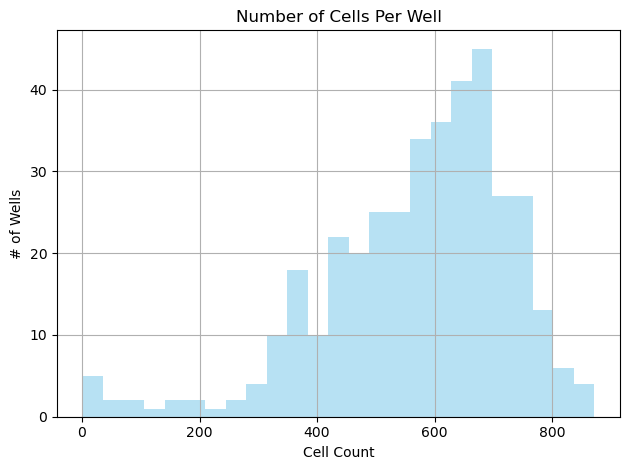

In [35]:
cells_per_well.hist(column=['Number_of_Cells'], bins=25, grid=True, alpha=0.6, color='skyblue')
plt.title('Number of Cells Per Well')
plt.xlabel('Cell Count')
plt.ylabel('# of Wells')
plt.tight_layout()
plt.show()

## Annotated Well & Field Statistics

Right now we only have extracted morphological features of plate no. 24278, so we take a subset of annotated wells of that plate:

In [36]:
# view the plate and compound information for plate 24278
biomorph_24278 = biomorph[biomorph.PlateID == 24278]
biomorph_24278

,PlateID,WellID,CPD_NAME,CPD_SAMPLE_ID,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease
103,24278,a03,olmesartan medoxomil,SA59556,0,0,0,0,0,0,0,0,0
104,24278,a06,citropten,SA59278,0,0,0,0,0,0,1,0,0
105,24278,a09,bromperidol,SA83338,0,0,0,0,0,0,0,0,0
106,24278,a10,leflunomide,SA792771,1,1,0,1,1,0,0,1,0
107,24278,a11,suxibuzone,SA58544,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,24278,p13,chlorpropamide,SA58227,0,0,0,0,0,0,0,0,0
198,24278,p14,nicorandil,SA83824,0,0,0,0,0,0,0,0,0
199,24278,p17,prednisolone,SA83046,0,0,0,0,0,0,0,0,0
200,24278,p21,chlorzoxazone,SA82767,0,0,0,0,0,0,0,0,0


Aggregating FOVs of each well, compute the mean and standard deviation of cells and nuclei area:

In [37]:
# # calculate the aggregated cell and nuclei metrics per well
# cell_agg_per_well = df_tables['Cells'].groupby('WellID').agg(Cells_AreaShape_Area_Mean=('Cells_AreaShape_Area', 'mean'),
#                                                Cells_AreaShape_Area_Std=('Cells_AreaShape_Area', 'std'),
#                                                Cells_AreaShape_Compactness_Mean=('Cells_AreaShape_Compactness', 'mean'),
#                                                Cells_AreaShape_Compactness_Std=('Cells_AreaShape_Compactness', 'std')).reset_index()

# nuclei_agg_per_well = df_tables['Nuclei'].groupby('WellID').agg(Nuclei_AreaShape_Area_Mean=('Nuclei_AreaShape_Area', 'mean'),
#                                                                       Nuclei_AreaShape_Area_Std=('Nuclei_AreaShape_Area', 'std'),
#                                                                       Nuclei_AreaShape_Compactness_Mean=('Nuclei_AreaShape_Compactness', 'mean'),
#                                                                       Nuclei_AreaShape_Compactness_Std=('Nuclei_AreaShape_Compactness', 'std')).reset_index()

# # merge aggregated metrics with the biomorph endpoints table
# biomorph_24278 = biomorph_24278.merge(cell_agg_per_well, on='WellID', how='left')
# biomorph_24278 = biomorph_24278.merge(nuclei_agg_per_well, on='WellID', how='left')
# biomorph_24278

Because the approach above resulted in less-than-ideal number of instances, let's aggregate for each FOV instead of each well:

In [38]:
# populate the endpoint dataframe with all available fields of each well
biomorph_24278 = biomorph_24278.merge(df_tables['Cells'][['WellID', 'FieldID']].drop_duplicates(), 
                     on=['WellID'], 
                     how='left')
biomorph_24278 = move_column(df=biomorph_24278, col_name='FieldID', new_position=2)

# calculate mean and standard deviation for 'Cells_AreaShape_Area' and 'Cells_AreaShape_Compactness' in cells_df by FieldID
cell_agg_per_field = df_tables['Cells'].groupby(['WellID', 'FieldID']).agg(
    Cells_AreaShape_Area_Mean=('Cells_AreaShape_Area', 'mean'),
    Cells_AreaShape_Area_Std=('Cells_AreaShape_Area', 'std'),
    Cells_AreaShape_Compactness_Mean=('Cells_AreaShape_Compactness', 'mean'),
    Cells_AreaShape_Compactness_Std=('Cells_AreaShape_Compactness', 'std')
).reset_index()

# calculate mean and standard deviation for 'Cells_AreaShape_Area' and 'Cells_AreaShape_Compactness' in nuclei_df by FieldID
nuclei_agg_per_field = df_tables['Nuclei'].groupby(['WellID', 'FieldID']).agg(
    Nuclei_AreaShape_Area_Mean=('Nuclei_AreaShape_Area', 'mean'),
    Nuclei_AreaShape_Area_Std=('Nuclei_AreaShape_Area', 'std'),
    Nuclei_AreaShape_Compactness_Mean=('Nuclei_AreaShape_Compactness', 'mean'),
    Nuclei_AreaShape_Compactness_Std=('Nuclei_AreaShape_Compactness', 'std')).reset_index()

# merge the aggregated metrics from cells_df into endpoint dataframe
biomorph_24278 = biomorph_24278.merge(cell_agg_per_field, on=['WellID', 'FieldID'], how='left')

# merge the aggregated metrics from nuclei_df into endpoint dataframe
biomorph_24278 = biomorph_24278.merge(nuclei_agg_per_field, on=['WellID', 'FieldID'], how='left')

# add the cell counts for each field of each well
biomorph_24278 = biomorph_24278.merge(cells_per_field, on=['WellID', 'FieldID'], how='left')
biomorph_24278 = move_column(df=biomorph_24278, col_name='Number_of_Cells', new_position=3)
biomorph_24278

,PlateID,WellID,FieldID,Number_of_Cells,CPD_NAME,CPD_SAMPLE_ID,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,...,oxidative stress up,proliferation decrease,Cells_AreaShape_Area_Mean,Cells_AreaShape_Area_Std,Cells_AreaShape_Compactness_Mean,Cells_AreaShape_Compactness_Std,Nuclei_AreaShape_Area_Mean,Nuclei_AreaShape_Area_Std,Nuclei_AreaShape_Compactness_Mean,Nuclei_AreaShape_Compactness_Std
0,24278,a03,s1,97,olmesartan medoxomil,SA59556,0,0,0,0,...,0,0,2697.989691,2184.240555,1.362183,0.320399,801.216495,353.681714,1.122623,0.097678
1,24278,a03,s2,110,olmesartan medoxomil,SA59556,0,0,0,0,...,0,0,2446.090909,1270.143419,1.369504,0.283888,798.418182,348.722502,1.133376,0.111364
2,24278,a03,s3,49,olmesartan medoxomil,SA59556,0,0,0,0,...,0,0,3826.408163,2494.539377,1.454695,0.437254,854.448980,374.762095,1.136081,0.106685
3,24278,a03,s4,74,olmesartan medoxomil,SA59556,0,0,0,0,...,0,0,3483.702703,2104.109617,1.546692,0.533525,821.567568,385.582643,1.148037,0.172811
4,24278,a03,s5,61,olmesartan medoxomil,SA59556,0,0,0,0,...,0,0,3414.852459,1483.216065,1.573668,0.464460,739.688525,224.409042,1.110631,0.080053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,24278,p24,s2,57,desoxycortone,SA83656,0,0,0,0,...,1,0,3666.929825,2204.959911,1.440640,0.498276,897.403509,198.123596,1.107520,0.068485
586,24278,p24,s3,88,desoxycortone,SA83656,0,0,0,0,...,1,0,3127.181818,1271.077030,1.285873,0.197321,907.613636,316.189650,1.093066,0.067408
587,24278,p24,s4,64,desoxycortone,SA83656,0,0,0,0,...,1,0,3760.078125,3013.942697,1.391001,0.439591,982.187500,308.844589,1.110976,0.094672
588,24278,p24,s5,109,desoxycortone,SA83656,0,0,0,0,...,1,0,2613.385321,1066.018300,1.335813,0.254134,870.412844,325.029036,1.102646,0.102073


## Cell Coordinates Inside FOVs (Pictures)

- Cell coordinate information of inside each (well) FOV doesn't complement to other FOVs inside the well.
- Therefore it's not possible to extract any information regarding connected neighourhoods between FOVs, because cells from different FOVs seem to overlap.
- Each FOV will be treated individually.

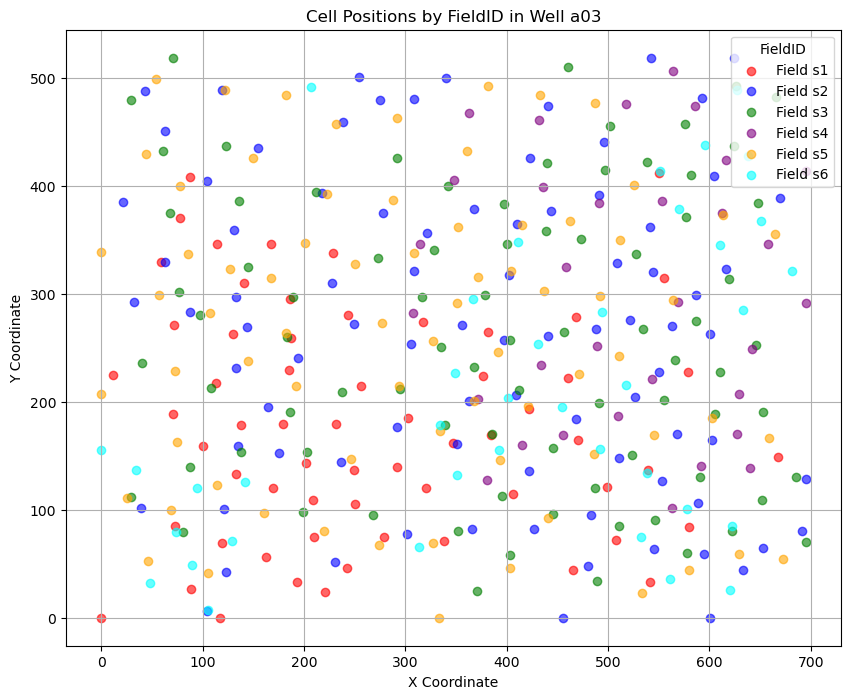

In [39]:
# copy a sample dataframe to view a snippet of cell positions
test = df_tables['Cells'][(df_tables['Cells'].WellID == 'a06')]

# define colors for each FieldID
field_colors = {
    's1': 'red',
    's2': 'blue',
    's3': 'green',
    's4': 'purple',
    's5': 'orange',
    's6': 'cyan'
}

plt.figure(figsize=(10, 8))

# plot each FieldID group separately
for field_id, color in field_colors.items():
    # filter cells for the current FieldID
    field_data = test[test['FieldID'] == field_id]
    # plot the cells for this FieldID
    plt.scatter(field_data['Cells_AreaShape_Center_X'], field_data['Cells_AreaShape_Center_Y'], label=f'Field {field_id}', color=color, alpha=0.6)


# label the axes and add a legend
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Cell Positions by FieldID in Well a03')
plt.legend(title='FieldID')
plt.grid(True)
plt.show()

## Compound & Endpoint Distribution

In [40]:
print(f'Number of plates with endpoint annotation: {len(biomorph['PlateID'].unique())}')
print(f'Number of compounds with endpoint annotation: {len(biomorph['CPD_NAME'].unique())}\n')

# number of unique compounds and compound occurrence counts
compound_occurrence = biomorph['CPD_NAME'].value_counts()
print(f'Compound occurrence counts:\n{compound_occurrence}')

Number of plates with endpoint annotation: 94
Number of compounds with endpoint annotation: 603

Compound occurrence counts:
CPD_NAME
propranolol            24
anabasine              24
timolol                24
bucladesine            23
sulpiride              23
                       ..
dobutamine              4
adenosine               4
1,10-phenanthroline     4
amiodarone              4
cefazolin               4
Name: count, Length: 603, dtype: int64


In [41]:
# create a column with total endpoint sum
biomorph['total_endpoints'] = biomorph[endpoint_columns].sum(axis=1)

# filter out the samples with singular endpoint activity
# biomorph[biomorph['total_endpoints'] > 1]

print(f"The number of samples with no endpoint activity: {biomorph[biomorph['total_endpoints'] == 0].shape[0]}")
print(f"The number of samples with a singular endpoint activity: {biomorph[biomorph['total_endpoints'] == 1].shape[0]}")
print(f"The number of samples with a multiple endpoint activities: {biomorph[biomorph['total_endpoints'] > 1].shape[0]}")

The number of samples with no endpoint activity: 2942
The number of samples with a singular endpoint activity: 868
The number of samples with a multiple endpoint activities: 1215


In [42]:
# add a column with a tuple list of total endpoint activities
biomorph['endpoint_combination'] = biomorph[endpoint_columns].apply(tuple, axis=1)

# retrieve the occurrence counts of endpoint activities
endpoint_combination_counts = biomorph['endpoint_combination'].value_counts()

# group by endpoint combination and then count unique compounds in each group
endpoint_compound_counts = biomorph.groupby('endpoint_combination')['CPD_NAME'].nunique()
endpoint_compound_counts = endpoint_compound_counts.sort_values(ascending=False)

print(f'Endpoint Combination Counts:\n{endpoint_combination_counts}\n')
print(f'Endpoint Compound Counts:\n{endpoint_compound_counts}')

Endpoint Combination Counts:
endpoint_combination
(0, 0, 0, 0, 0, 0, 0, 0, 0)    2942
(1, 0, 0, 0, 0, 0, 0, 0, 0)     317
(0, 1, 0, 0, 0, 0, 0, 0, 0)     281
(0, 0, 0, 0, 0, 0, 0, 1, 0)     118
(1, 1, 0, 0, 0, 0, 0, 0, 0)     117
                               ... 
(0, 0, 0, 1, 1, 0, 1, 1, 1)       8
(1, 0, 0, 0, 0, 1, 1, 1, 1)       8
(1, 0, 1, 0, 0, 0, 0, 0, 0)       8
(1, 0, 1, 0, 1, 0, 0, 1, 1)       8
(1, 1, 0, 1, 1, 0, 1, 0, 1)       4
Name: count, Length: 79, dtype: int64

Endpoint Compound Counts:
endpoint_combination
(0, 0, 0, 0, 0, 0, 0, 0, 0)    350
(1, 0, 0, 0, 0, 0, 0, 0, 0)     41
(0, 1, 0, 0, 0, 0, 0, 0, 0)     33
(0, 0, 0, 0, 0, 0, 0, 1, 0)     14
(1, 1, 0, 0, 0, 0, 0, 0, 0)     14
                              ... 
(1, 0, 1, 0, 0, 0, 0, 1, 1)      1
(0, 0, 1, 1, 0, 1, 1, 1, 1)      1
(1, 0, 1, 0, 1, 0, 0, 1, 1)      1
(0, 0, 1, 1, 0, 0, 1, 1, 1)      1
(0, 1, 1, 1, 1, 0, 0, 0, 1)      1
Name: CPD_NAME, Length: 79, dtype: int64


In [43]:
# all of the compounds only results in a single endpoint combination
for eachCompound in biomorph['CPD_NAME'].unique():
    if len(biomorph[biomorph['CPD_NAME'] == eachCompound]['endpoint_combination'].unique()) != 1:
        print(f"{eachCompound} has multiple occurring endpoint combinations")

In [44]:
# calculate total occurrences of each compound
compound_counts = biomorph['CPD_NAME'].value_counts().reset_index()
compound_counts.columns = ['CPD_NAME', 'Total_Occurrences']

# find the most frequent endpoint combination for each compound
most_common_combinations = biomorph.groupby(['CPD_NAME', 'endpoint_combination']).size().reset_index(name='Count')
most_common_combinations = most_common_combinations.sort_values(['CPD_NAME', 'Count'], ascending=[True, False])

# get the top combination for each compound
most_common_combinations = most_common_combinations.drop_duplicates(subset='CPD_NAME', keep='first')

# merge with total occurrences and calculate decimal percentage
compound_summary = pd.merge(compound_counts, most_common_combinations, on='CPD_NAME')
compound_summary['Decimal_Percentage'] = compound_summary['Count'] / compound_summary['Total_Occurrences']

# rename columns for clarity
compound_summary.columns = ['CPD_NAME', 'Total_Occurrences', 'Most_Common_Combination', 'Occurrence_with_Combination', 'Decimal_Percentage']

# sort by total occurrences in descending order
compound_summary = compound_summary.sort_values(by='Total_Occurrences', ascending=False).reset_index(drop=True)
compound_summary

,CPD_NAME,Total_Occurrences,Most_Common_Combination,Occurrence_with_Combination,Decimal_Percentage
0,propranolol,24,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",24,1.0
1,timolol,24,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",24,1.0
2,anabasine,24,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",24,1.0
3,bucladesine,23,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",23,1.0
4,sulpiride,23,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",23,1.0
...,...,...,...,...,...
598,dobutamine,4,"(1, 0, 0, 0, 0, 0, 0, 0, 0)",4,1.0
599,adenosine,4,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",4,1.0
600,"1,10-phenanthroline",4,"(1, 1, 0, 1, 1, 0, 1, 0, 1)",4,1.0
601,amiodarone,4,"(0, 1, 0, 0, 0, 0, 0, 0, 0)",4,1.0


## Compound Statistics

In [46]:
compound_area_stats = biomorph_24278.groupby('CPD_NAME').agg(
    Mean_Cell_Area=('Cells_AreaShape_Area_Mean', 'mean'),
    Std_Cell_Area=('Cells_AreaShape_Area_Std', 'mean'),
    Mean_Cell_Area_Variance=('Cells_AreaShape_Area_Std', 'var')  # Optional: to also include variance of std deviations across fields
).reset_index()

compound_area_stats

,CPD_NAME,Mean_Cell_Area,Std_Cell_Area,Mean_Cell_Area_Variance
0,"1,3,5-trimethoxybenzene",2722.524157,1613.295384,3.404084e+05
1,"2,4,5-trichlorophenoxyacetic acid",2293.436035,1249.210087,4.881087e+04
2,albendazole,4091.069486,2417.623901,3.475904e+05
3,ami-193,2751.969789,1415.548849,1.205643e+05
4,amiloride,3234.224446,1514.842621,2.992151e+05
...,...,...,...,...
94,tinidazole,2120.586031,1186.353988,1.411436e+05
95,tolbutamide,2374.893845,1082.267040,2.765689e+04
96,trapidil,2664.738386,1186.220452,4.822213e+04
97,triamterene,2705.350566,1630.717404,1.020939e+06


In [61]:
len(biomorph.CPD_NAME.unique())

603

## Linking Compound Groupings with Phenotypic(endpoints?) and Spatial Information
- Endpoint combination counts for each compound (this way because endpoints combinations are around 80 and compounds are around 600)
    - "For each compound type (mostly the heavily occuring ones) what are the most common endpoint combinations?"
- For each compound: number of cells (?), mean cell area, variance of cell area, mean and variance of *Cells_AreaShape_Compactness*, and the density of the cells (i.e. the size of the neighborhood)(will be searched through Summer et al., 2022)

# 3. Classifier Modeling

- Since each endpoint represents a separate type of activity, building ***separate classifiers*** for each endpoint (like apoptosis up) is a reasonable approach. This way, each classifier can be optimized for the characteristics of its specific endpoint. However, if these endpoints are often activated together, a multi-label classification model could be beneficial, as it learns patterns across the endpoints simultaneously. **Next: The potential for multi-label will be investigated.**

- Including ***compound names*** could be useful since certain compounds are known to induce specific responses, but encoding must be done carefully. **Next: Categorical data encoding will be investigated.**
- Scaling using ***StandardScaler*** is done to mitigate potential sensitivity problems that might occur in feature-scale-sensitive model types. Random forest is not one of them, but still it is good practice.
- Since each WellID has multiple FieldIDs, treating them as groups using ***StratifiedGroupKFold*** ensures that fields from the same well don’t appear in both training and test sets, preventing data leakage and preserving the independence of samples.

In [55]:
# list of predictor columns
predictor_columns = [
    'Number_of_Cells', 'Cells_AreaShape_Area_Mean', 'Cells_AreaShape_Area_Std',
    'Cells_AreaShape_Compactness_Mean', 'Cells_AreaShape_Compactness_Std',
    'Nuclei_AreaShape_Area_Mean', 'Nuclei_AreaShape_Area_Std',
    'Nuclei_AreaShape_Compactness_Mean', 'Nuclei_AreaShape_Compactness_Std'
]

X = biomorph_24278[predictor_columns]
y = biomorph_24278['apoptosis up']
groups = biomorph_24278['WellID']  # grouping by WellID to ensure fields stay together in splits

# initialize StratifiedGroupKFold
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# initialize random forest pipeline with scaling included
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('classifier', RandomForestClassifier(random_state=42))])

# list of scores for evaluation
accuracies = []
roc_aucs = []

# start the stratification of group cross-validation
for train_index, test_index in skf.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # fit the pipeline (that includes both scaler and classifier) on training data
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    accuracies.append(accuracy)
    roc_aucs.append(roc_auc)

print(f"Accuracy List: {accuracies}")
print(f"ROC AUC List: {roc_aucs}")

print(f"Mean Accuracy: {sum(accuracies) / len(accuracies):.2f}")
print(f"Mean ROC AUC: {sum(roc_aucs) / len(roc_aucs):.2f}")

Accuracy List: [0.6293103448275862, 0.6916666666666667, 0.7017543859649122, 0.7142857142857143, 0.8245614035087719]
ROC AUC List: [0.5326704545454546, 0.5659722222222221, 0.6282051282051282, 0.5429526748971193, 0.5367476851851851]
Mean Accuracy: 0.71
Mean ROC AUC: 0.56
